In [101]:
from lxml import objectify
import pandas as pd
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [102]:
def plot(x,y=None):
    if y==None:
        tmp = range(len(x))
        y = x
        x = tmp
    fig, ax = plt.subplots(figsize=(16,2))
    ax.plot(x,y)
    plt.show()

In [103]:
path=r'dataset/REFIT_BUILDING_SURVEY.xml'
tree = objectify.parse(path)
root = tree.getroot()
NS={'a':'http://www.refitsmarthomes.org'}

path=r'dataset/REFIT_TIME_SERIES_VALUES.csv'
if csv is None:
    csv=pd.read_csv(path, index_col=0, parse_dates=[1])

In [104]:
#Energy consumption in home
def get_energy():
    """
        Available only for 1st building, due to needs a lot of memory on drive
    """
    
    path = r'dataset/CLEAN_House1.csv'
    csvnrg=pd.read_csv(path, header=0,usecols=["Time", "Aggregate"], parse_dates=[0])

    data_en = csvnrg['Aggregate'].tolist()[:100000]
    time_en = csvnrg['Time'].tolist()[:100000]

#     plot(time_en, data_en)
    
    return data_en, time_en

In [105]:
#Values of (gas based) Radiator temperature sensor
def get_radiator(building_num=1, rad_num=2):
    appliance = 'Radiator[%d]' % (rad_num)
    NS={'a':'http://www.refitsmarthomes.org'}
    
    radiators = root.xpath('./a:Stock/a:Building[%d]/a:%s' % (building_num, appliance), namespaces=NS)

    data_rad = []
    time_rad = []

    for rad in radiators:
        r_id = rad.get('id')
        t = []
        v = []
        for sensor in rad.getchildren():
            for time_series_variable in sensor.getchildren():
                id = time_series_variable.get('id')
                t.append(csv.loc[id]['dateTime'].tolist())
                v.append(csv.loc[id]['data'].values.tolist())
        data_rad = list(itertools.chain.from_iterable(v))
        time_rad = list(itertools.chain.from_iterable(t))
    
    return data_rad, time_rad

In [106]:
#Summs values for intervals

by_day = lambda t: t.day
by_week = lambda t: t.week
by_month = lambda t: t.month
    
act_sum = lambda s, vi: s + vi
act_max = lambda s, vi: max(s,vi)
act_min = lambda s, vi: min(s,vi)
    
def act_interval(check_param, action, times, values):
    t = []
    v = []
    s = values[0]
    for i in range(1, len(times)):
        if check_param(times[i]) == check_param(times[i-1]):
            s = action(s, values[i])
        else:
            v.append(s)
            t.append(times[i])
            s = values[i]
    return t,v

In [107]:
#Usage of gas in home

def get_gas(building_num=1):
    appliance = 1 #Number of gas meter
    NS={'a':'http://www.refitsmarthomes.org'}
    tsv = root.xpath('./a:Stock/a:Building[%d]/a:Meter[%d]/a:Sensor/a:TimeSeriesVariable' % (building_num, appliance), namespaces=NS)

    id = tsv[0].get('id')

    time_gas = csv.loc[id]['dateTime'].tolist()
    data_gas = csv.loc[id]['data'].values.tolist()
    
    time_gas, data_gas = act_interval(by_day, act_sum, time_gas, data_gas)
    
    return data_gas, time_gas


def get_fft(data):
    from numpy.fft import rfft
    fg = rfft(data).real
#     print('gas day sum FFT coefficients')
#     plot(fg)
#     len(fg)
    
    return fg

In [108]:
#Weather data 
def get_clim():
    NS={'a':'http://www.refitsmarthomes.org'}
    elements=root.xpath('./a:Stock/a:Climate/a:Sensor/a:TimeSeriesVariable', namespaces=NS)
    data_clim = []
    time_clim = []
    for e in elements:
        id = e.get('id')
        variable_type=e.get('variableType')
        units=e.get('units')
        t,v = act_interval(by_day, act_min, csv.loc[id]['dateTime'].tolist(), csv.loc[id]['data'].tolist())
        data_clim.append(v)
        if len(time_clim) == 0:
            time_clim = t
        else: 
            assert len(time_clim) == len(t)
    
    return data_clim, time_clim
#         ax.plot(csv.loc[id]['dateTime'],csv.loc[id]['data'])
#         plt.show()

In [109]:
# e = elements[0]
# climate_sensors = []
# for i in elements:
#     climate_sensors.append(i.attrib['variableType'])
# print(climate_sensors)
# #indexes: 0, 1, 2, -2, -1

# RNN (LSTM) building

In [110]:
#TODO: try LSTM model to predict gas consumption 

#Changeable parameters:
# building_num = 2      #Begins from 1 (not 0) ):
# gap = 7               #len (days before now) for FFT (for input layer of LSTM)

def prepare_data(building_num=2, gap=7):
    data_gas, time_gas = get_gas(building_num)
    data_clim, time_clim = get_clim()

    print('Initial data:')
    print('len(gas): ', len(time_gas))
    print('len(clim): ', len(time_clim))

    #align dates in intervals
    #meter must be @gap days before now
    #climate must begin day after now (tommorow)

    print('First possible date of gas (with gap shifting): ', time_gas[gap])
    print('First date of clim: ', time_clim[0])
    begin = time_gas.index(time_clim[0]) - gap
    time_gas = time_gas[begin:]
    data_gas = data_gas[begin:]

    end = time_clim.index(time_gas[-1]) + 1
    time_clim = time_clim[:end]

    print('After formatting: ')
    print(len(time_gas))
    print(len(time_clim))
    print('first')
    print(time_gas[gap])
    print(time_clim[0])

    print('last')
    print(time_gas[-1])
    print(time_clim[-1])

    tmp = []
    for d in data_clim:
        tmp.append(d[:end])
    data_clim = tmp
    
    #Prepare data to train LSTM

    xinp = [] #Construct of 0-3: FFT coefficients, 4-weather forecast values on tommorow
    ypred = []

    for idx in range(gap, len(time_gas)-1):
        item = time_gas[idx]
        row = rfft(data_gas[idx-gap:idx]).real.tolist()
        ypred.append(data_gas[idx+1])
        #add weather forecast
        widx = time_clim.index(item) #weather's series index for current date
        row.append(data_clim[0][widx+1])
        row.append(data_clim[1][widx+1])
        row.append(data_clim[2][widx+1])
        row.append(data_clim[-2][widx+1])
        row.append(data_clim[-1][widx+1])

        xinp.append(row)

    print(xinp[-1])
    print(ypred[-1])
    
    return xinp, ypred

In [111]:
#Store input and output
import pickle
import os.path

def get_data(building_num=2, gap=7):
    finp = 'inp_building=%d_gap=%d.pkl' % (building_num, gap)
    fout = 'out_building=%d_gap=%d.pkl' % (building_num, gap)

    if os.path.exists(finp) and os.path.exists(fout):
        with open('inp.pkl', 'rb') as f:
            X = pickle.load(f)
        with open('pred.pkl', 'rb') as f:
            Y = pickle.load(f)
    else:
        X,Y = prepare_data(building_num, gap)
        
        #Store
        with open(finp, 'wb') as f:
            pickle.dump(X, f)
        with open(fout, 'wb') as f:
            pickle.dump(Y, f)
            
    return numpy.array(X).astype('float32'), numpy.array(Y).astype('float32').reshape(-1,1)

        
        
        
def saveAsText(xinp, ypred):
    with open('inp.txt', 'w') as f:
        for i in xinp:
            f.write(', '.join(map(str, i)))
            f.write('\n')
    with open('out.txt', 'w') as f:
        for i in ypred:
            f.write(str(i))
            f.write('\n')

# model begins here

In [118]:
#Train LSTM

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [134]:
# frameX = pandas.read_csv('inp.txt', engine='python')
# setX = frameX.values
# setX = setX.astype('float32')

building=2
gap=20
split = 0.67
neurons = 50
epochs = 40

setX, setY = get_data(building, gap)

# normalize the setX
scalerX = MinMaxScaler(feature_range=(0, 1))
setX = scalerX.fit_transform(setX)

print(len(setX))

# split into train and test sets
train_size = int(len(setX) * split)
test_size = len(setX) - train_size
train, test = setX[0:train_size,:], setX[train_size:len(setX),:]
print(len(train), len(test))


#TODO: тут вроде как только reshape функция полезная
# convert an array of values into a setX matrix
def create_dataset(dataset):
    dataX = numpy.array(dataset)
    
    # reshape input to be [samples, time steps, features] (was [samples, features])
    dataX = numpy.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1])) 
    
    return dataX

trainX = create_dataset(train)
testX = create_dataset(test)


# frameY = pandas.read_csv('out.txt', engine='python')
# setY = frameY.values
# setY = setY.astype('float32')

#Scale
scalerY = MinMaxScaler(feature_range=(0, 1))
setY = scalerY.fit_transform(setY)

trainY, testY = setY[0:train_size,:], setY[train_size:len(setY),:]
print(len(trainY), len(testY))

Initial data:
len(gas):  596
len(clim):  574
First possible date of gas (with gap shifting):  2013-10-05 00:00:00
First date of clim:  2013-11-05 00:00:00
After formatting: 
565
548
first
2013-11-05 00:00:00
2013-11-05 00:00:00
last
2015-05-06 00:00:00
2015-05-06 00:00:00
[23.85, 3.2904256719501133, -2.544270509831246, -0.8430710656285754, -1.6727457514062622, -4.8599999999999985, -2.5107294901687505, -0.4940804174710831, -1.9522542485937344, 2.7067258111495374, 0.9099999999999984, 9.03, 52.23, 0.654, 0.0, 978.0]
0.0
544
364 180
364 180


C:\Users\Ford\Anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
 - 4s - loss: 0.0316
Train Score: 0.95 RMSE
Test Score: 1.18 RMSE
Epoch 1/1
 - 3s - loss: 0.0149
Train Score: 0.92 RMSE
Test Score: 1.14 RMSE
Epoch 1/1
 - 3s - loss: 0.0142
Train Score: 1.06 RMSE
Test Score: 1.19 RMSE
Epoch 1/1
 - 3s - loss: 0.0138
Train Score: 0.95 RMSE
Test Score: 1.14 RMSE
Epoch 1/1
 - 3s - loss: 0.0129
Train Score: 0.90 RMSE
Test Score: 1.20 RMSE
Epoch 1/1
 - 3s - loss: 0.0134
Train Score: 0.88 RMSE
Test Score: 1.20 RMSE
Epoch 1/1
 - 3s - loss: 0.0129
Train Score: 0.94 RMSE
Test Score: 1.13 RMSE
Epoch 1/1
 - 3s - loss: 0.0140
Train Score: 0.89 RMSE
Test Score: 1.22 RMSE
Epoch 1/1
 - 3s - loss: 0.0124
Train Score: 0.87 RMSE
Test Score: 1.19 RMSE
Epoch 1/1
 - 3s - loss: 0.0127
Train Score: 1.02 RMSE
Test Score: 1.16 RMSE
Epoch 1/1
 - 3s - loss: 0.0126
Train Score: 0.95 RMSE
Test Score: 1.31 RMSE
Epoch 1/1
 - 3s - loss: 0.0128
Train Score: 0.89 RMSE
Test Score: 1.19 RMSE
Epoch 1/1
 - 3s - loss: 0.0127
Train Score: 0.90 RMSE
Test Score: 1.28 RMSE
Epoch 1/1
 -

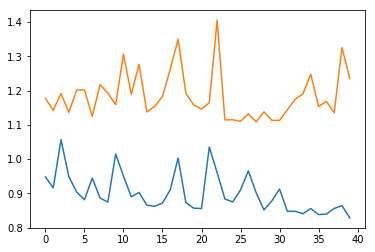

In [135]:
#design and fit our LSTM network



model = Sequential()
model.add(LSTM(neurons, input_shape=(1, trainX.shape[2]))) #,return_sequences=True
# model.add(LSTM(neurons))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# history = model.fit(trainX, trainY, epochs=epochs, batch_size=1, verbose=2)
tr = []
te = []
for i in range(epochs):
    history = model.fit(trainX, trainY, nb_epoch=1, batch_size=1, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scalerY.inverse_transform(trainPredict)
    trY = scalerY.inverse_transform(trainY)
    testPredict = scalerY.inverse_transform(testPredict)
    teY = scalerY.inverse_transform(testY)
    # calculate root mean squared error
    tmp = mean_squared_error(trY, trainPredict[:,0])
    trainScore = math.sqrt(tmp)
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(teY, testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    tr.append(trainScore)
    te.append(testScore)
plt.plot(tr)
plt.plot(te)
plt.show()
    

In [136]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scalerY.inverse_transform(trainPredict)
trainY = scalerY.inverse_transform(trainY)
testPredict = scalerY.inverse_transform(testPredict)
testY = scalerY.inverse_transform(testY)
# calculate root mean squared error
tmp = mean_squared_error(trainY, trainPredict[:,0])
trainScore = math.sqrt(tmp)
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.83 RMSE
Test Score: 1.24 RMSE


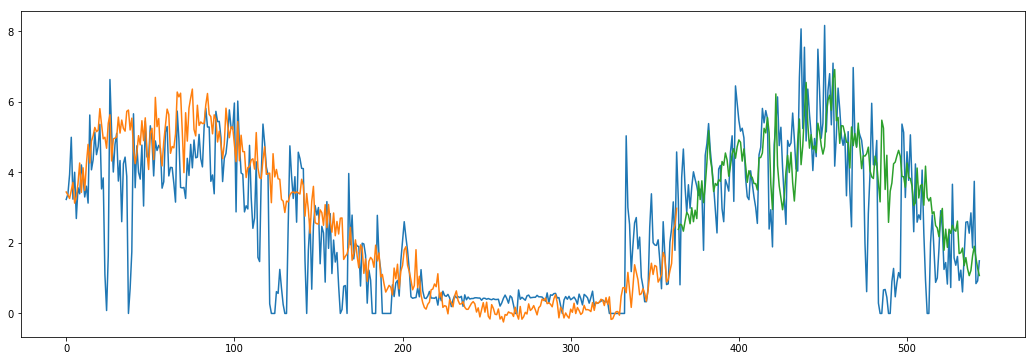

In [138]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(valset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[:len(trainPredict), :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(valset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(valset), :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(scalerY.inverse_transform(valset))
ax.plot(trainPredictPlot)
ax.plot(testPredictPlot)
plt.show()

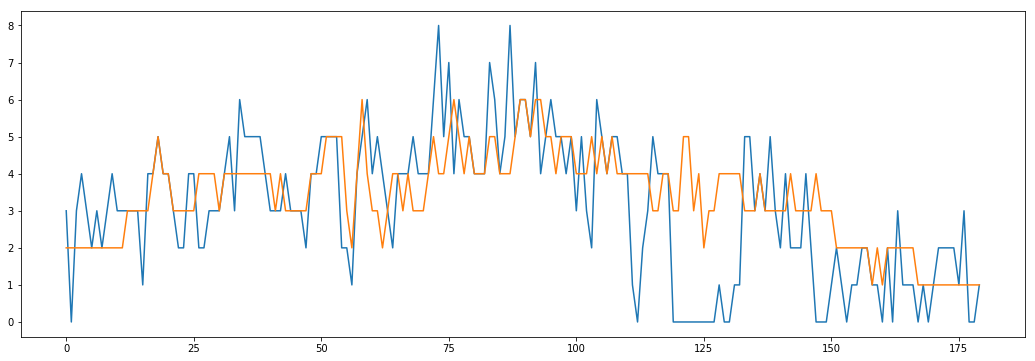

In [139]:
a = list(map(int, scalerY.inverse_transform(valset[len(trainPredict):])))
b = list(map(int, testPredict))
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(a)
ax.plot(b)
plt.show()